In [12]:
import glob
import os, time
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
from datetime import datetime, timedelta

from scipy.stats import norm
from scipy.optimize import curve_fit #we could import more, but this is what we need
from scipy.stats import linregress

from scipy import sparse
from scipy.sparse.linalg import spsolve
from pybaselines import Baseline, utils

from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy import fftpack
from scipy.fftpack import fft, ifft

%matplotlib inline

In [13]:
'''
Get paths to corresponsing folders
'''

# get the path to the project's main directory (e.g., Project051)
BASE_DIR_PATH = os.path.dirname(os.path.abspath(os.getcwd()))

# ------------------------- data folder -----------------------

# get the path to the folder containing raw data
DATA_DIR_PATH = os.path.join(BASE_DIR_PATH, 'data','')

# get the path to the folder containing UV-Vis-NIR raw data
DATA_UV_DIR_PATH_AGGREGATION = os.path.join(BASE_DIR_PATH, 'data', 'UV-Vis-NIR','2024-01-26-100ns-20nr-25nacl-100h2o-7bp2','17c-2-2a','')

# ------------------------- output folder -----------------------

# # get the path to the folder with generated figures
RESULT_DIR_PATH = os.path.join(BASE_DIR_PATH, 'results', 'figs', '')


In [14]:
'''
Import cooling data from UV-Vis-NIR folder
'''

#================ import data =========================#

# Define the path to the folder containing the CSV files
folder_path = DATA_UV_DIR_PATH_AGGREGATION

# Get a list of all CSV files in the folder
txt_files = glob.glob(os.path.join(folder_path, '*.txt'))

print(len(txt_files))

#================ plot data heating cycle ===========================#

# fig = plt.figure(figsize=(4,2), dpi=300) # generate a figure
# ax = plt.subplot(1,1,1) #(nrow, ncolumn, index) - make a subplot, there is only one

# Initialize the maximum value and its corresponding index
max_values_cool = []
max_indexes_cool = []
wv_abs_cool = []
times_cool = []

time_cool = 0

for i, txt_file in enumerate(natsorted(txt_files)):
    # Read the CSV file into a Pandas DataFrame
    df_cool = pd.read_csv(txt_file, skiprows=14, delimiter='\t', header=None)
    new_df_cool = df_cool.iloc[400:1200, ] #385 to 743 nm
    
    # Find the maximum value and its corresponding index
    max_value_cool = new_df_cool.iloc[667,1] # 685 nm
    max_values_cool.append(max_value_cool)
    
    # Get the corresponding value from the first column
    max_index_cool = new_df_cool.loc[new_df_cool.idxmax(), 0]
    max_indexes_cool.append(max_index_cool)
    
    times_cool.append(time_cool)
    time_cool = time_cool + 2 # 2 seconds
    
    # set the color

    if i == 0:
        color = 'firebrick'
    elif i == len(txt_files)-1:
        color = 'royalblue'
    else:
        color = 'grey'
    
    # Plot the data
#     ax.plot(df_cool[0],df_cool[1], color = color, linewidth = 1)                           # plot data

# ax.set_xlim([350,800])                    # set wavelength limit
# ax.set_ylim([-0.1,0.8])                       # set absorbance limit
# ax.set_xlabel(r'Wavelength (nm)')          # set axis label
# ax.set_ylabel(r'Extinction ')              # set axis label
# ax.axvline(685, color='firebrick')

# plt.tight_layout()  


# Plot of max. wavelength with time

# fig = plt.figure(figsize=(4,2), dpi=600) # generate a figure
# ax = plt.subplot(1,1,1) #(nrow, ncolumn, index) - make a subplot, there is only one

# ax.plot(times_cool, max_values_cool, linewidth = 1, color = 'royalblue')                           # plot data
# #ax.set_title('17$^{o}$C-3.3A-35mins-Wavelength')

# #ax.set_xlim([3300,4000])                   
# #ax.set_ylim([0.3,0.51])                       
# ax.set_xlabel(r'Time(s)')          # set axis label
# ax.set_ylabel(r'Abs. 685')              # set axis label

# plt.tight_layout()  

# fig = plt.figure(figsize=(4,2), dpi=600) # generate a figure
# ax = plt.subplot(1,1,1) #(nrow, ncolumn, index) - make a subplot, there is only one

# ax.plot(times_cool, max_indexes_cool, linewidth = 1, color = 'royalblue')                           # plot data
# #ax.set_title('17$^{o}$C-3.3A-35mins-Wavelength')

# #ax.set_xlim([3300,4000])                   
# #ax.set_ylim([0.3,0.51])                       
# ax.set_xlabel(r'Time(s)')          # set axis label
# ax.set_ylabel(r'Abs. 685')              # set axis label

# plt.tight_layout()  


1893


## Calculating Baseline

In [15]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [16]:
baseline_als(max_values_cool,  lam=1e7, p=0.2)

array([0.1334453 , 0.13362404, 0.13380278, ..., 0.32813097, 0.32818437,
       0.32823778])

In [17]:
base_corr = (max_values_cool - (baseline_als(max_values_cool,  lam=1.0E6, p=0.5)))

base_corr[1000:1500]

print(len(base_corr[1000:1500]))

500


In [18]:
# fig = plt.figure(figsize=(7,3), dpi=100) # generate a figure
# ax = plt.subplot(1,1,1) #(nrow, ncolumn, index) - make a subplot, there is only one

# ax.plot(base_corr[500:1000], linewidth = 1, color = 'firebrick')                           # plot data
# #ax.set_title('17$^{o}$C-3.3A-35mins-Wavelength')

# #ax.set_xlim([500,2000])                   
# #ax.set_ylim([600,700])                       
# ax.set_xlabel(r'Time (s)')          # set axis label
# ax.set_ylabel(r'Ext. @ 685 nm')              # set axis label
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.tight_layout()  

In [19]:
signal = base_corr[500:1000]

# Number of sample points
N = len(base_corr[500:1000])
# sample spacing
sampling_rate = 0.5

yf = fft(base_corr[500:1000])
xf = fftfreq(N, d=1.0/sampling_rate)


Frequencies of the peaks:
0.002
0.006
0.008
0.036000000000000004


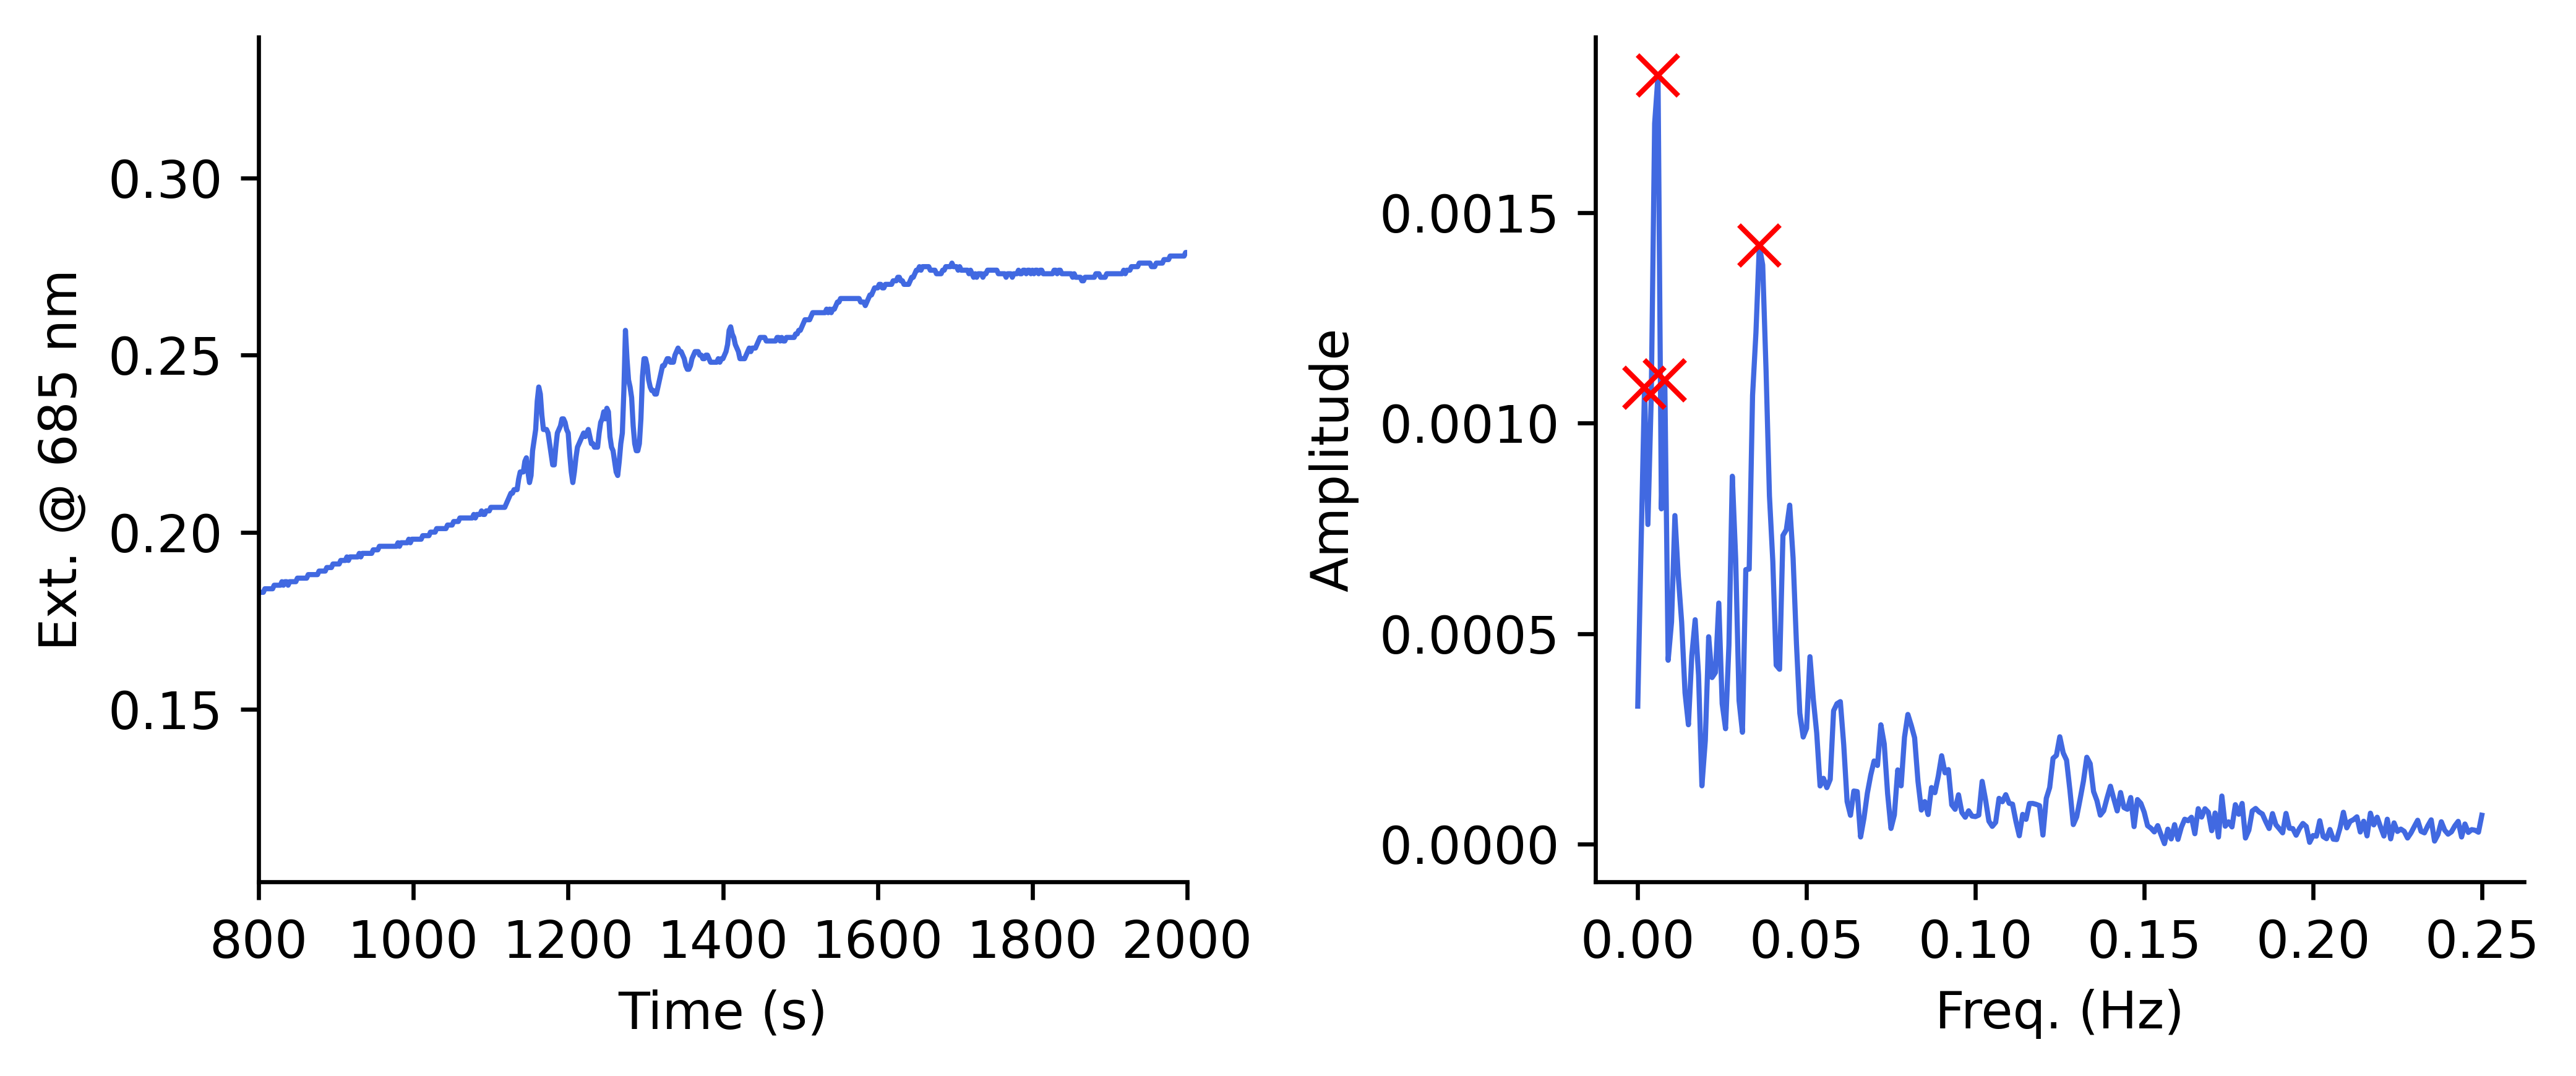

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.gridspec import GridSpec

# Assuming times_cool, max_values_cool, baseline_als, N, sampling_rate, and signal are defined

fig = plt.figure(figsize=(7, 3), dpi=600)
gs = GridSpec(1, 2)  # nrows, ncols
ax1 = fig.add_subplot(gs[0, 0])  # upper left subplot
ax2 = fig.add_subplot(gs[0, 1])  # upper right subplot

# Plot baseline-corrected data
ax1.plot(times_cool, (max_values_cool), linewidth=1, color='royalblue')
ax1.set_xlim([800, 2000])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Ext. @ 685 nm')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Perform Fourier transform and plot
freqs = np.fft.rfftfreq(N, d=1/sampling_rate)
fft_values = np.abs(np.fft.rfft(signal))
ax2.plot(freqs, 2*fft_values/N, linewidth=1, color='royalblue')
ax2.set_xlabel('Freq. (Hz)')
ax2.set_ylabel('Amplitude')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Find peaks in the Fourier transform plot
peaks, _ = find_peaks(2*fft_values/N, height=0.001)
ax2.plot(freqs[peaks], (2*fft_values/N)[peaks], 'x', color='red', markersize=8)

# Print frequencies of the peaks
print("Frequencies of the peaks:")
for peak_index in peaks:
    print(freqs[peak_index])

plt.tight_layout()
fig.savefig(RESULT_DIR_PATH + 'Fig_4f_top.png', transparent=True)
plt.show()
